# Comparing Dasymetic Mapping methods for City of Chesapeake, Viginia

The goal of this notebook is to explore dasymetric mapping mthods in City of Chesapeake, Virginia.

Dasymetric mapping is a technique used to improve the accuracy of population mapping. In the United States, census data is widely used to analyze the spatial distribution of socio-economic factors. For instance, the American Community Survey (ACS, available at https://www.census.gov/programs-surveys/acs) compiles crucial socio-economic data at the census tract level. While census boundaries cover entire states, the population is not evenly distributed but tends to concentrate in residential areas. Dasymetric mapping, in combination with other datasets like land use and land cover, enhances the precision of mapping results.

This notebook applies two python packages including:
1. Tobler, a geostatistic pytho package based on PySAL: https://github.com/pysal/tobler.
2. The EnviroAtlas Intelligent Dasymetric Toolbox: https://github.com/USEPA/Dasymetric-Toolbox-ArcGISPro

The steps are as follows:
1. Load OpenStreetMap, Census, and land use land cover data for the residential area.
2. Apply Tobler package
3. Apply EPA package
4. Compare Tobler and EPA outcomes

In [1]:
# Import required python library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm # for land use land cover plotting


# GeoSpatial related
import geopandas as gpd
from census import Census

# Census and OpenStreetMap related
#import pygeoda
from pygris import block_groups
from pygris.data import get_census
import osmnx as ox

# Geospatial data process & analysis related
import rioxarray
import rasterio
from rasterio.plot import show
from shapely.geometry import Polygon, LineString, Point
from split_donuts import split_donuts # This function require the split_donuts.py in local folder
from join_donuts import join_donuts # This function require the join_donuts.py in local folder

#from libpysal import weights
#import esda

# Geostatistic for dasymetric mapping 
import pysal
from tobler.area_weighted import area_interpolate
from tobler.dasymetric import masked_area_interpolate
from tobler.model import glm


## 1.1 Load OpenStreetMap data for the residential area.

OpenStreetMap (OSM) is a collaborative, open-source mapping project. With a global community of contributors, OSM provides a free and constantly evolving map of the world. The python library, osmnx, can be applied to retrieve residential area, which represents an area of land having predominantly residential buildings such as houses or apartment buildings.

For more information about:
- osmnx python library: https://osmnx.readthedocs.io/en/stable/
- OSM residential area: https://wiki.openstreetmap.org/wiki/Tag:landuse%3Dresidential

In [16]:
# Load OpenStreetMap (OSM) data for City of Chesapeake
cpc_ox_resi = ox.features.features_from_place ('Chesapeake,Virginia', tags={'landuse':'residential'})

# Remove the non-polygon part of data
cpc_ox_resi = cpc_ox_resi.loc[cpc_ox_resi.geometry.type=='Polygon'] 

# Convert to UTM coordinate system
cpc_ox_resi = cpc_ox_resi.to_crs("epsg:32618")

Some of the OSM residential data contain more complex polygon shape, including polygons with holes (referred to as "donuts"). These intricate polygons may not function optimally with one of the Tobler functions. To address this, we have introduced an additional function called "join_donuts" to simplify these polygons. For more information on the "join_donuts" function, please visit: https://github.com/fgassert/split_donuts/tree/master

In [17]:
# Save OSM data to a shpefile
# Filter column formet to avoid error (see: https://pygis.io/docs/d_access_osm.html)
cpc_ox_resi  = cpc_ox_resi.loc[:,cpc_ox_resi.columns.str.contains('addr:|geometry')] 
cpc_ox_resi.to_file ("cpc_ox_resi_ori.shp") 

# Run join donuts function and load it back to a geodataframe
# Hide shapely warning messages
import warnings 
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

join_donuts("cpc_ox_resi_ori.shp", "cpc_ox_resi_fixed.shp")
cpc_ox_resi_fixed = gpd.read_file("cpc_ox_resi_fixed.shp")

# Another way to fix donut polygons, feel free to try split donut function
#split_donuts("cpc_ox_resi_ori.shp", "cpc_ox_resi_fixed.shp")
#cpc_ox_resi_fixed = gpd.read_file("cpc_ox_resi_fixed.shp")

/tmp/ipykernel_1047054/1130694188.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cpc_ox_resi.to_file ("cpc_ox_resi_ori.shp")


Text(0.5, 1.0, 'OpenStreetMap Residential Area')

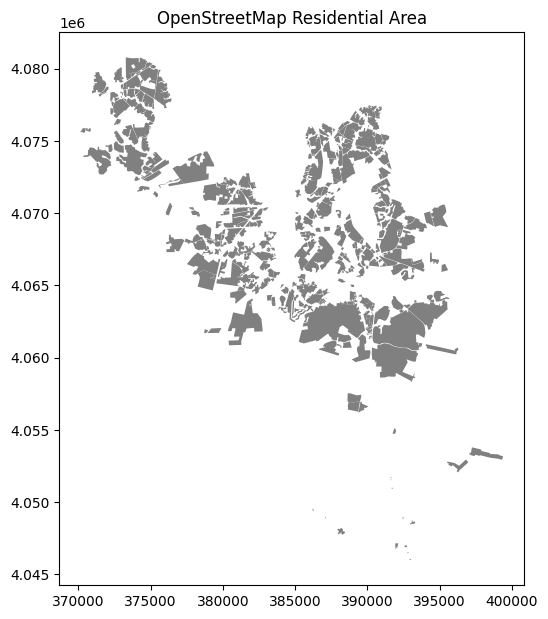

In [18]:
# Plot the OSM residential area
f,ax = plt.subplots(1,1, figsize=(6,8))
cpc_ox_resi_fixed.plot(linewidth=.25, ax=ax, color='gray')
ax.set_title("OpenStreetMap Residential Area")

# 1.2 Loading population data from the U.S. Census Bureau

There are several python package can be used to import data from U.S. Census Bureau. Here, pygris is utilized to retrieve Census Bureau TIGER/Line and cartographic boundary shapefiles and load them into Python as GeoDataFrames. For more infromation, see: https://walker-data.com/pygris/

Note that census block group data is retrieved here because the size if block group has similar size to OSM residential polygons.

In [19]:
# Load census block group data with pygris "block_groups" function as a GeoDataFrame
cpc_cbg = block_groups(state = "VA", county = "Chesapeake", year = 2020, cache = True)

Using FIPS code '51' for input 'VA'
Using FIPS code '550' for input 'Chesapeake'


In [20]:
# Make an interactive map to view the GeoDataFrame
cpc_cbg.explore(tooltip = False, popup = True ) #shows data when clicking

In [21]:
# Import census data, here census block data is first retrieved
CPC_data = get_census(
    dataset = "dec/dhc", # Decennial Census & Census Demographic and Housing Characteristics
    year = 2020,
    variables = ["P1_001N", # total population
                 "P5_003N", # total non-Hispanic white population
                 "P10_004N", #total population of African American
                 "P12_020N", # Variables P12_020N to P12_025N are total population for males ages 65 and over
                 "P12Z_003N", # males under 5 years old
                 "P12_021N",
                 "P12_022N",
                 "P12_023N",
                 "P12_024N",
                 "P12_025N",
                 "P12_044N", # Variables P12_044N to P12_049N are total population for females ages 65 and over
                 "P12_045N",
                 "P12_046N",
                 "P12_047N",
                 "P12_048N",
                 "P12_049N",
                 "P12Z_027N" # females under 5 years old
                ],
    params = {
        "for": "block:*",
        "in": ["state:51", "county:550"] # here define the State / County code, CPC code as 
    },
    return_geoid = True,
    guess_dtypes = True
)

# Preview census data
CPC_data.head()

,P1_001N,P5_003N,P10_004N,P12_020N,P12Z_003N,P12_021N,P12_022N,P12_023N,P12_024N,P12_025N,P12_044N,P12_045N,P12_046N,P12_047N,P12_048N,P12_049N,P12Z_027N,GEOID
0,38,16,12,0,0,0,0,0,0,0,0,0,2,0,0,0,0,515500204002024
1,22,12,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,515500204002021
2,26,17,3,0,0,0,0,0,0,0,1,0,0,3,1,0,0,515500204002022
3,108,7,69,0,0,0,0,0,0,0,1,1,0,3,0,0,0,515500204002023
4,63,30,18,0,0,2,0,0,1,0,0,0,0,0,1,0,0,515500204003000


In [22]:
# Aggregrate data from census block to census block group lavel
CPC_data['CBG_ID'] = CPC_data['GEOID'].str[:-3]
CPC_data = CPC_data.drop('GEOID', axis=1) # drop the GEOID column

CPC_CBGdata = CPC_data.groupby(['CBG_ID']).sum()
CPC_CBGdata.reset_index()

# Preview census block group data
CPC_CBGdata.head()

,P1_001N,P5_003N,P10_004N,P12_020N,P12Z_003N,P12_021N,P12_022N,P12_023N,P12_024N,P12_025N,P12_044N,P12_045N,P12_046N,P12_047N,P12_048N,P12_049N,P12Z_027N
CBG_ID,,,,,,,,,,,,,,,,,
515500200011,1642,1196,145,23,2,25,37,29,25,20,29,33,42,36,27,35,6
515500200021,1232,812,133,14,1,25,21,14,5,9,20,16,27,10,14,11,5
515500200022,1765,513,743,6,0,8,5,9,0,6,20,11,17,14,6,6,1
515500200023,1325,671,317,27,0,16,32,20,13,7,24,17,29,26,5,13,2
515500200031,1383,506,430,7,2,9,18,11,2,2,14,11,17,15,13,10,4


In [23]:
# Merge above census block group data to the GeoDataFrame
CPC_geo = cpc_cbg[['GEOID', 'geometry', 'ALAND']].merge(CPC_CBGdata, left_on = "GEOID", right_on = "CBG_ID")

# Calculate population density, unit of ALAND20 is square meter, here convert to to hectare
CPC_geo["pop_density"] = CPC_geo["P1_001N"] / (CPC_geo["ALAND"]/10000) #

# Calculate percentage of African American
CPC_geo["percent_AA"] = CPC_geo["P10_004N"] / CPC_geo["P1_001N"] 

# Calculate total population including and above 65 years old
CPC_geo["senior_pop"] = CPC_geo["P12_020N"] + CPC_geo["P12_021N"] + CPC_geo["P12_022N"] + CPC_geo["P12_023N"] + CPC_geo["P12_024N"] + CPC_geo["P12_025N"] + CPC_geo["P12_044N"] + CPC_geo["P12_045N"] + CPC_geo["P12_046N"] + CPC_geo["P12_047N"] + CPC_geo["P12_048N"]

# Calculate medically fragile population of less than 5 years and older than 65 years for males and females of all races
CPC_geo["med_frag_pop"] = CPC_geo["P12_020N"] + CPC_geo["P12_021N"] + CPC_geo["P12_022N"] + CPC_geo["P12_023N"] + CPC_geo["P12_024N"] + CPC_geo["P12_025N"] + CPC_geo["P12_044N"] + CPC_geo["P12_045N"] + CPC_geo["P12_046N"] + CPC_geo["P12_047N"] + CPC_geo["P12_048N"] + CPC_geo["P12Z_027N"] + CPC_geo["P12Z_003N"]

# replace 0's with NAs
CPC_geo.fillna(0, inplace = True)

# remove block with zero land area and zero population
CPC_geo = CPC_geo[CPC_geo.ALAND != 0]
CPC_geo = CPC_geo[CPC_geo.P1_001N != 0] 

# reproject to UTM coordinate system
CPC_geo = CPC_geo.to_crs("epsg:32618")

# Preview data frame
CPC_geo.head()

,GEOID,geometry,ALAND,P1_001N,P5_003N,P10_004N,P12_020N,P12Z_003N,P12_021N,P12_022N,...,P12_045N,P12_046N,P12_047N,P12_048N,P12_049N,P12Z_027N,pop_density,percent_AA,senior_pop,med_frag_pop
0,515500210092,"POLYGON ((390788.481 4060366.291, 390788.247 4...",4246653,2753,2245,107,31,13,30,51,...,31,47,28,15,19,3,6.482752,0.038867,310,326
1,515500211012,"POLYGON ((391937.953 4064724.798, 392175.187 4...",3465329,1804,1471,73,25,5,36,44,...,33,40,29,12,12,4,5.205855,0.040466,273,282
2,515500211011,"POLYGON ((389277.580 4064628.774, 389510.126 4...",4075638,2050,1700,63,31,3,36,48,...,34,61,51,28,28,1,5.029887,0.030732,393,397
3,515500201004,"POLYGON ((388513.251 4074614.470, 388519.755 4...",197220,905,30,450,3,1,2,10,...,7,5,2,10,2,0,45.887841,0.497238,49,50
4,515500207003,"POLYGON ((387605.895 4072147.947, 387668.779 4...",435235,1007,280,504,31,0,34,41,...,40,92,62,40,41,3,23.136926,0.500497,433,436


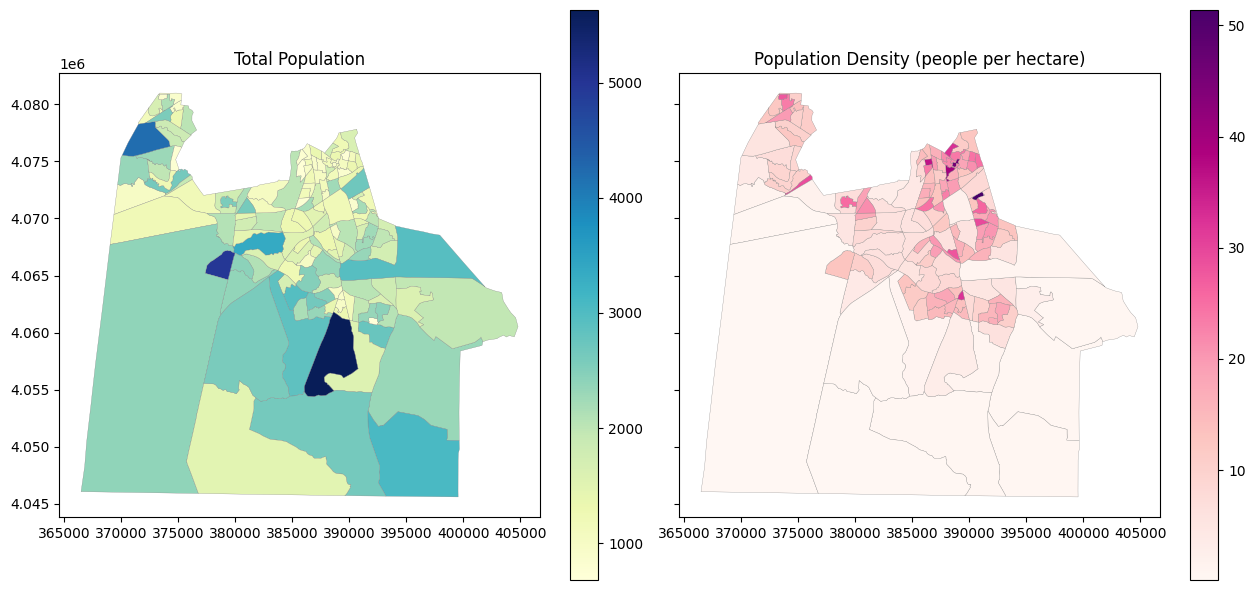

In [24]:
# Plot census block data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)

ax1 = CPC_geo.plot(ax=ax1, column = 'P1_001N', legend=True, edgecolor="gray", 
                   linewidth=0.2, cmap='YlGnBu')
ax1.set_title("Total Population")
ax2 = CPC_geo.plot(ax=ax2, column = 'pop_density', legend=True, edgecolor="gray", 
                   linewidth=0.2, cmap='RdPu')
ax2.set_title("Population Density (people per hectare)")
plt.tight_layout()

In [25]:
#Explore the results of the above with a focus on medically fragile population
#   For more info on geoPandas explore function: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html
CPC_geo.explore("med_frag_pop", #Optional to explore a specific variable
                scheme = "Percentiles", #optional classification shceme
                k = 5, #number of classes
                tooltip = False, # Display GeoDataFrame attributes when hovering over the object
                popup = True #shows data when clicking
                )

## 1.3. Load land use and land cover data from the National Land Cover Database

The National Land Cover Database (NLCD) offers comprehensive land cover and land use data for the entire United States. If you'd like to learn more about NLCD, you can visit their website here: https://www.usgs.gov/centers/eros/science/national-land-cover-database

A 2019 NLCD for City of Chesapeake was clipped and saved in the local folder.

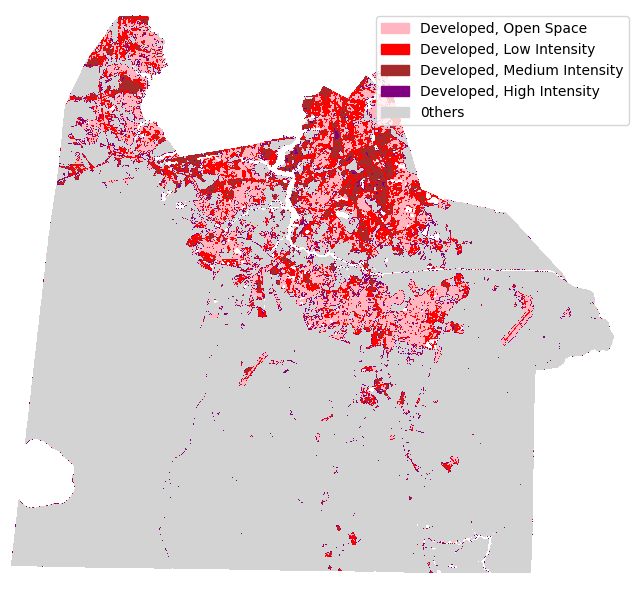

In [26]:
# Load NLCD data and make a quick map
nlcd_cpc = rioxarray.open_rasterio("AIST_NLCD_2019_CPC_16bit.tif").squeeze() # this Tiff file is with UTM projection already

# Create a color map and call specific classification for visualization
cmap = ListedColormap(["white", "lightpink", "red", "brown", "purple", "lightgray"])
norm = colors.BoundaryNorm([11, 21, 22, 23, 24, 31, 52], 7) # This define the classes

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(nlcd_cpc, cmap=cmap, norm=norm)
legend_labels = {"lightpink": "Developed, Open Space",  # Create a legend to indicate the land use land cover type
                 "red": "Developed, Low Intensity", 
                 "brown": "Developed, Medium Intensity",
                 "purple": "Developed, High Intensity",
                 "lightgray": "0thers"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
ax.legend(handles=patches,
          bbox_to_anchor=(1.01, 1),
          facecolor="white")
ax.set_axis_off() # Hide the X and Y becuase imshow does not plot with UTM X and Y values properly
plt.show()

## 2. Apply Tobler dasymetric mapping methods

Dasymetric mapping aims to focus on residential areas and map where the population resides. We applied the Tobler library for interpolation, which uses data from census tracts, residential areas, and land use land cover data. In Tobler, there are three mapping methods that we will apply and compare:

1. Generalized Linear Model (GLM): A statistic modeling method that consider the relationship between the target variable and a set of covariates characteristics.

2. Areal Interpolation (AI): The simplest method for allocating variables based on overlapping geometries.

3. Masked Area Interpolation (MAI): Similar to areal interpolation, this method incorporates auxiliary data (e.g., NLCD) to enhance estimations.

In [27]:
# Call NLCD again as proper format for Tobler function
nlcd_cpcfile = "./AIST_NLCD_2019_CPC_16bit.tif" 

# Apply Generalized Linear Model (GLM) method
glm_popden_oxres = glm(source_df=CPC_geo, target_df=cpc_ox_resi_fixed, 
                       raster=nlcd_cpcfile, raster_codes=[21, 22, 23, 24], 
                       variable="P1_001N")
glm_popden_oxres["area"] = glm_popden_oxres["geometry"].area/ 10000
glm_popden_oxres["Population_density_glm"] = glm_popden_oxres["P1_001N"] / glm_popden_oxres["area"]
glm_popden_oxres = glm_popden_oxres.rename(columns ={"P1_001N":'Total_population_glm'})

# Apply Areal Interpolation (AI) method
AI_popden_oxres = area_interpolate(source_df=CPC_geo, target_df=cpc_ox_resi_fixed, 
                                   extensive_variables=['P1_001N'])
AI_popden_oxres["area"] = AI_popden_oxres["geometry"].area/ 10000
AI_popden_oxres["Population_density_AI"] = AI_popden_oxres["P1_001N"] / AI_popden_oxres["area"]
AI_popden_oxres = AI_popden_oxres.rename(columns ={"P1_001N":"Total_population_AI"})

# Apply Masked Areal Interpolation (MAI) method
MAI_popden_oxres = masked_area_interpolate (source_df=CPC_geo, target_df=cpc_ox_resi_fixed, 
                                            raster=nlcd_cpcfile, pixel_values=[21, 22, 23, 24],
                                            extensive_variables=["P1_001N"])
MAI_popden_oxres["area"] = MAI_popden_oxres["geometry"].area/ 10000
MAI_popden_oxres["Population_density_MAI"] = MAI_popden_oxres["P1_001N"] / MAI_popden_oxres["area"]
MAI_popden_oxres = MAI_popden_oxres.rename(columns ={"P1_001N":"Total_population_MAI"})


/opt/tljh/user/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/tljh/user/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

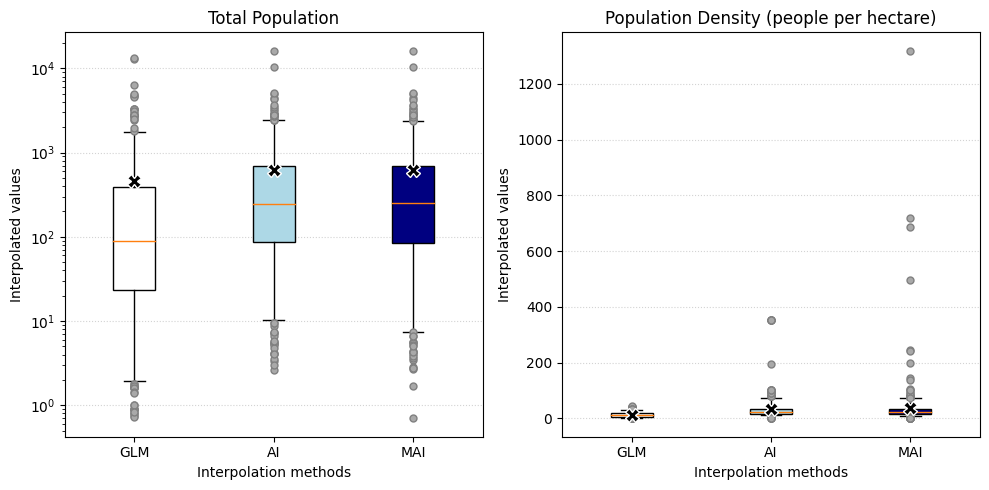

In [29]:
# Clean up the geodataframes and merge them into one dataframe
resultdf = glm_popden_oxres.merge(AI_popden_oxres, left_index=True, right_index=True).merge(MAI_popden_oxres, left_index=True, right_index=True)
resultdf = resultdf [["geometry","Total_population_glm", "Total_population_AI", "Total_population_MAI",
                     "Population_density_glm", "Population_density_AI", "Population_density_MAI"]]

# Create boxplots to show the distribution of outcomes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# Set styles for outlier and mean
flierprops = dict(marker='.', markerfacecolor='darkgray', markersize=10,
                  markeredgecolor="gray")
meanpointprops = dict(marker='X', markeredgecolor='white', markersize=10,
                      markerfacecolor='black')

labels = ["GLM", "AI", "MAI"]
bplot1 = ax1.boxplot(resultdf [["Total_population_glm", "Total_population_AI", "Total_population_MAI"]],
                     vert=True, flierprops=flierprops, meanprops=meanpointprops,
                     showmeans = True, patch_artist=True, whis = (5,95), # whisker showing 5 and 95 percentiles
                     labels=labels) 
ax1.set_yscale('log')
ax1.set_title("Total Population")

bplot2 = ax2.boxplot(resultdf [["Population_density_glm", "Population_density_AI", "Population_density_MAI"]],
                     vert=True, flierprops=flierprops, meanprops=meanpointprops,
                     showmeans = True, patch_artist=True, whis = (5,95), # whisker showing 5 and 95 percentiles
                     labels=labels) 
ax2.set_title("Population Density (people per hectare)")

# Set colors of boxs
colors = ["white", "lightblue", "navy"]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)

# Add grid-line and x & y labels
for ax in [ax1, ax2]:
    ax.yaxis.grid(color="lightgray", linestyle="dotted")
    ax.set_xlabel("Interpolation methods")
    ax.set_ylabel("Interpolated values")

plt.tight_layout()

/tmp/ipykernel_1047054/1580654396.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


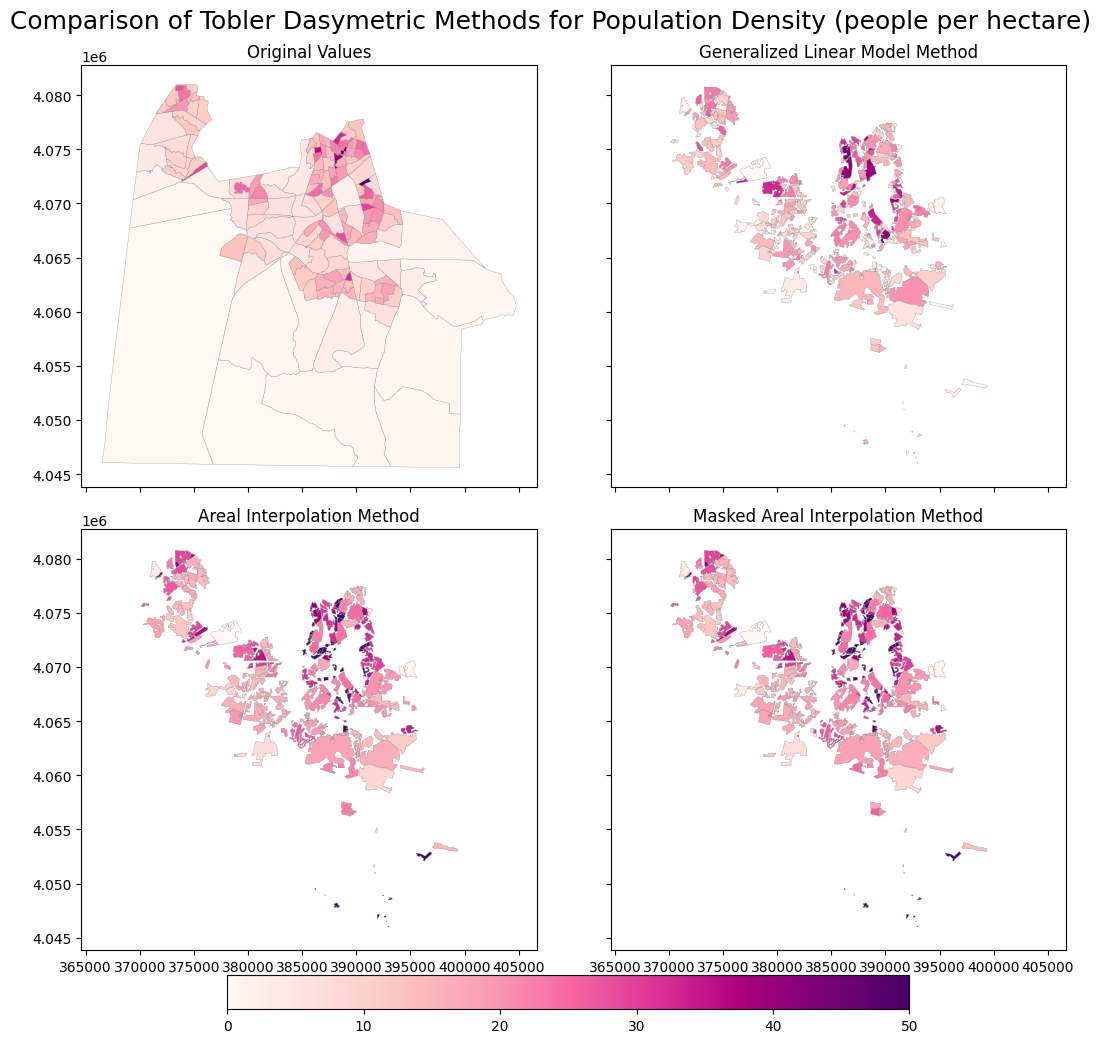

In [30]:
# Make a side-by-side map showing the outcomes
fig, axs = plt.subplots(2, 2, figsize=(11, 10), sharex=True, sharey=True)
fig.suptitle ("Comparison of Tobler Dasymetric Methods for Population Density (people per hectare) ",  fontsize=18)

# Define the minimum and maximum values for plotting
vmin = 0
vmax = 50 # set to 50 for better visualization

# Plot original data
axs[0,0] = CPC_geo.plot(ax=axs[0][0], column = 'pop_density', edgecolor="gray", 
                        linewidth=0.2, vmin=vmin, vmax=vmax, cmap='RdPu')
axs[0,0].set_title("Original Values")

# Plot Generalized Linear Model result
axs[0,1] = glm_popden_oxres.plot(ax=axs[0][1],column = 'Population_density_glm', edgecolor="gray", 
                                        linewidth=0.2, vmin=vmin, vmax=vmax, cmap='RdPu')
axs[0,1].set_title("Generalized Linear Model Method")

# Plot Areal Interpolation result
axs[1,0] = AI_popden_oxres.plot(ax=axs[1][0], column = 'Population_density_AI', edgecolor="gray", 
                                linewidth=0.2, vmin=vmin, vmax=vmax, cmap='RdPu')
axs[1,0].set_title("Areal Interpolation Method")

# Plot Masked Areal Interpolation result
axs[1,1] = MAI_popden_oxres.plot(ax=axs[1][1], column = 'Population_density_MAI', edgecolor="gray", 
                                 linewidth=0.2, vmin=vmin, vmax=vmax, cmap='RdPu')
axs[1,1].set_title("Masked Areal Interpolation Method")

# Define color bar on the bottom
patch_col = axs[0,0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, orientation='horizontal', shrink= 0.8, location = "bottom", anchor=(0.5, -1.6))
plt.subplots_adjust(bottom=0.1)

plt.tight_layout()


### EPA IDM Function
Below is the whole function for doing an intelligent dasymetric mapping of population. You may find more information above on their github and please attribute accordingly. 
Please look at the function carefully to understand how the parameters described earlier are being used.

In [2]:
# We will import the IDM function as a module 
from idm import dasy_map 
import json

In [32]:
# Read in and view the default config.json
# Define the file paths
input_file_path = "./config.json"  

# Read the JSON file
with open(input_file_path, "r") as json_file:
    data = json.load(json_file)

# Print the JSON data
print(json.dumps(data, indent=4))

{
    "0": 0,
    "11": 0,
    "31": 0,
    "90": 0,
    "91": 0
}


In [4]:
# Load the AIST data for the EPA tool
popFeat_path = "./ches_modified_blocks.shp"
popCountField = 'P1_001N' #'P1_001N' is total population;  #P1_001M is medically fragile
popKeyField = 'unique_id'
ancRaster_path = './AIST_NLCD_2019_26918.tif' #26918 is the EPSG code
out_dir = './output_EPA_ches_medFrag/'
#uninhab_path = './data/uninhab_DE.shp'
presetTable = './config.json'

In [5]:
#Run the tool
dasy_map(popFeat_path = popFeat_path, #path to population polygons
         popCountField = popCountField, #field name for population count
         popKeyField = popKeyField, #key ID 
         ancRaster_path = ancRaster_path, #path to landcover raster 
         out_dir = out_dir, #path to output folder  
         popAreaMin = 10, # was 5 for blocks
         sampleMin = 2,  #was 3 for blocks
         percent = 0.51,  # was 0.95 for blocks
         #uninhab_path = uninhab_path, 
         anc_nd = 255, #no data value for raster 
         pop_nd = 255)

population_features path: ./ches_modified_blocks.shp
population_count_field: P1_001N
population_key_field: unique_id
ancillary_raster: ./AIST_NLCD_2019_26918.tif
uninhabited_file: False
The minimum populated area of a representative unit is 10
The minimum sample size is 2
The percent is 0.51
The NoData value for the population raster is 255
The NoData value for the ancillary raster is 255
Creating population raster...
Creating dasymetric units...


FileNotFoundError: [Errno 2] No such file or directory: '/opt/tljh/user/lib/python3.9/site-packages/config.json'

/opt/tljh/user/lib/python3.9/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


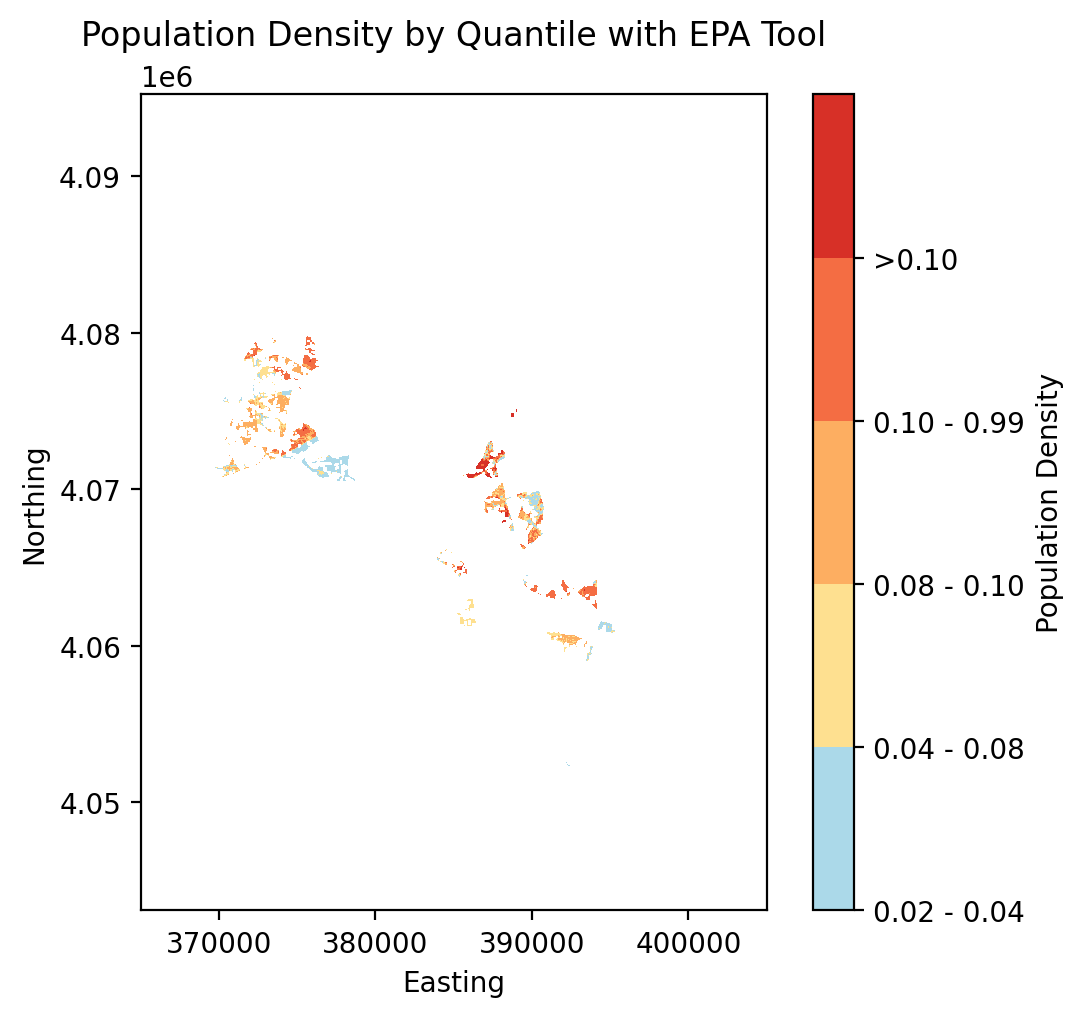

In [38]:
# File path to the GeoTIFF you want to visualize
geotiff_path = './output_EPA_ches_medFrag/DensityRaster.tif'

# Read the GeoTIFF using rasterio
with rasterio.open(geotiff_path) as src:
    # Read the raster data
    raster_data = src.read(1, masked=True)
    
    # Mask out zero values
    raster_data = np.ma.masked_where(raster_data == 0, raster_data)

    # Calculate quantiles
    values = raster_data[~raster_data.mask]
    quantiles = np.percentile(values, [20, 40, 60, 80, 100])

    # Assign values to quantile classes
    classes = np.digitize(raster_data, quantiles)

    # Mask NoData values
    classes = np.ma.masked_where(raster_data.mask, classes)

    # Define the reversed colormap and norm
    colors = ['#abd9e9', '#fee090', '#fdae61', '#f46d43', '#d73027']  
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(len(quantiles) + 1), len(colors))

    # Create the plot with zoom
    fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
    img = ax.imshow(classes, cmap=cmap, norm=norm, extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])

    # Set the limits to zoom in on a specific region
    ax.set_xlim(365000, 405000)  # Set the limits for x-axis
    ax.set_ylim(4043088, 4095219)  # Set the limits for y-axis

    # Create colorbar with quantile ranges as labels
    tick_labels = [f'{quantiles[i]:.2f} - {quantiles[i+1]:.2f}' for i in range(len(quantiles) - 1)]
    tick_labels.append(f'>{quantiles[-2]:.2f}')  # Ensure the last label shows the highest quantile

    cbar = plt.colorbar(img, ticks=np.arange(len(quantiles)), label='Population Density')
    cbar.ax.set_yticklabels(tick_labels)
    
    fig.subplots_adjust(bottom=0.2)

    plt.title('Population Density by Quantile with EPA Tool', y=1.04)
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    plt.grid(False)
    plt.show()

### Zonal Statistics to Check Outputs

In [ ]:
#Gather data outputs from all functions


In [ ]:
# Multiply by area of ancillary datasets for relavent outputs



# Run Zonal Sum to compare outputs